# Backpropagation in Multilayer Neural Networks

### Goals: 
- Diving deep: implement a real gradient descent in `Numpy`

### Dataset:
- Similar as first Lab - Digits: 10 class handwritten digits
- [sklearn.datasets.load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)

In [1]:
#load watermark
%load_ext watermark
%watermark -a 'Gopala KR' -u -d -v -p watermark,numpy,matplotlib,tensorflow

/srv/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Gopala KR 
last updated: 2018-03-04 

CPython 3.6.3
IPython 6.2.1

watermark 1.6.0
numpy 1.14.1
matplotlib 2.1.2
tensorflow 1.6.0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

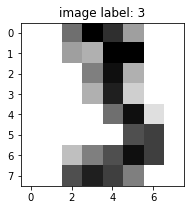

In [3]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- Normalization
- Train / test split

In [4]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(scaler.mean_)
# print(scaler.scale_)

In [5]:
X_train.shape

(1527, 64)

In [6]:
X_train.dtype

dtype('float32')

In [7]:
X_test.shape

(270, 64)

In [8]:
y_train.shape

(1527,)

In [9]:
y_train.dtype

dtype('int32')

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement a simple forward model with no hidden layer (equivalent to a logistic regression):
note: shape, transpose of W with regards to course
$y = softmax(\mathbf{W} \dot x + b)$

- Build a predict function which returns the most probable class given an input $x$

- Build an accuracy function for a batch of inputs $X$ and the corresponding expected outputs $y_{true}$

- Build a grad function which computes $\frac{d}{dW} -\log(softmax(W \dot x + b))$ for an $x$ and its corresponding expected output $y_{true}$ ; check that the gradients are well defined

- Build a train function which uses the grad function output to update $\mathbf{W}$ and $b$


### One-hot encoding for class label data

First let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes (similar to keras' `to_categorical`):

In [10]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [11]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [12]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now let's implement the softmax vector function:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [13]:
def softmax(X):
    # TODO:
    return None

Make sure that this works one vector at a time (and check that the components sum to one):

In [14]:
print(softmax([10, 2, -3]))

None


Note that a naive implementation of softmax might not be able process a batch of activations in a single call:

In [15]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

None


Here is a way to implement softmax that works both for an individal vector of activations and for a batch of activation vectors at once:

In [16]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)


print("softmax of a single vector:")
print(softmax([10, 2, -3]))

softmax of a single vector:
[9.99662391e-01 3.35349373e-04 2.25956630e-06]


Probabilities should sum to 1:

In [17]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [18]:
print("sotfmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

sotfmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [19]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Implement a function that given the true one-hot encoded class `Y_true` and and some predicted probabilities `Y_pred` returns the negative log likelihood.

In [20]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)
    
    # TODO
    return 0.


# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.0


Check that the nll of a very confident yet bad prediction is a much higher positive number:

In [21]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

0.0


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [22]:
def nll(Y_true, Y_pred):
    Y_true = np.atleast_2d(Y_true)
    Y_pred = np.atleast_2d(Y_pred)

    # TODO
    return 0.

In [23]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.0


In [24]:
# %load solutions/numpy_nll.py

Let us now study the following linear model trainable by SGD, **one sample at a time**.

In [25]:
class LogisticRegression():

    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        self.output_size = output_size
        
    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)
    
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
    def grad_loss(self, x, y_true):
        y_pred = self.forward(x)
        dnll_output =  y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
        grads = {"W": grad_W, "b": grad_b}
        return grads
    
    def train(self, x, y, learning_rate):
        # Traditional SGD update without momentum
        grads = self.grad_loss(x, y)
        self.W = self.W - learning_rate * grads["W"]
        self.b = self.b - learning_rate * grads["b"]      
        
    def loss(self, x, y):
        return nll(one_hot(self.output_size, y), self.forward(x))

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [26]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 0.0000, train acc: 0.089, test acc: 0.085


Evaluate the randomly initialized model on the first example:

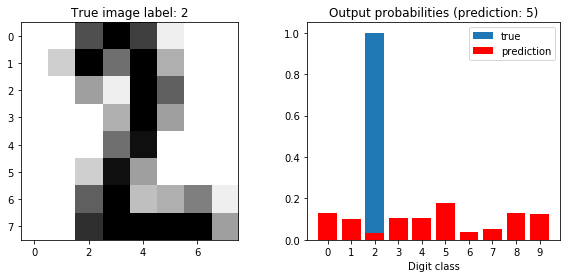

In [27]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(scaler.inverse_transform(X_test[sample_idx]).reshape(8, 8), cmap=plt.cm.gray_r,
               interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()
    
plot_prediction(lr, sample_idx=0)

In [28]:
# Training for one epoch
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X_train, y_train)):
    lr.train(x, y, learning_rate)
    if i % 100 == 0:
        train_loss = lr.loss(X_train, y_train)
        train_acc = lr.accuracy(X_train, y_train)
        test_acc = lr.accuracy(X_test, y_test)
        print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
              % (i, train_loss, train_acc, test_acc))

Update #0, train loss: 0.0000, train acc: 0.093, test acc: 0.089
Update #100, train loss: 0.0000, train acc: 0.710, test acc: 0.726
Update #200, train loss: 0.0000, train acc: 0.842, test acc: 0.859
Update #300, train loss: 0.0000, train acc: 0.896, test acc: 0.911
Update #400, train loss: 0.0000, train acc: 0.898, test acc: 0.922
Update #500, train loss: 0.0000, train acc: 0.908, test acc: 0.937
Update #600, train loss: 0.0000, train acc: 0.924, test acc: 0.933
Update #700, train loss: 0.0000, train acc: 0.929, test acc: 0.948
Update #800, train loss: 0.0000, train acc: 0.934, test acc: 0.959
Update #900, train loss: 0.0000, train acc: 0.938, test acc: 0.952
Update #1000, train loss: 0.0000, train acc: 0.939, test acc: 0.959
Update #1100, train loss: 0.0000, train acc: 0.941, test acc: 0.963
Update #1200, train loss: 0.0000, train acc: 0.942, test acc: 0.963
Update #1300, train loss: 0.0000, train acc: 0.948, test acc: 0.948
Update #1400, train loss: 0.0000, train acc: 0.949, test acc

Evaluate the trained model on the first example:

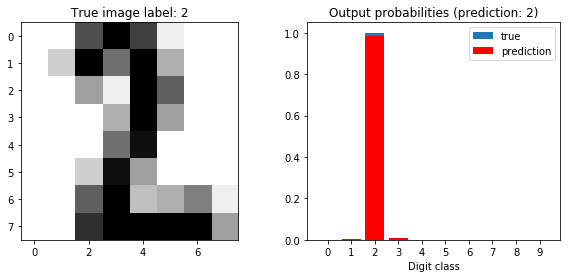

In [29]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

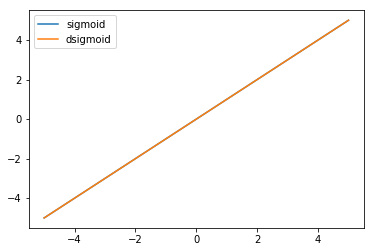

In [30]:
def sigmoid(X):
    # TODO
    return X


def dsigmoid(X):
    # TODO
    return X


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

In [31]:
# %load solutions/sigmoid.py

- Implement `forward` and `forward_keep_all` functions for a model with a hidden layer with a sigmoid activation function:
  - $\mathbf{h} = sigmoid(\mathbf{W}^h \mathbf{x} + \mathbf{b^h})$
  - $\mathbf{y} = softmax(\mathbf{W}^o \mathbf{h} + \mathbf{b^o})$

- Notes: 
  - try to keep the code as similar as possible as the previous one;
  - `forward_keep_activations` is similar to forward, but also returns hidden activations and pre activations;

- Update the grad function to compute all gradients; check that the gradients are well defined;

- Implement the `train` and `loss` functions.

**Bonus**: reimplementing all from scratch only using the lecture slides but without looking at the solution of the `LogisticRegression` is an excellent exercise.

In [32]:
EPSILON = 1e-8


class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""
    
    def __init__(self, input_size, hidden_size, output_size):
        # TODO
        self.W_h = None
        self.b_h = None
        self.W_o = None
        self.b_o = None
        self.output_size = output_size
        
    def forward(self, X):
        # TODO
        if len(X.shape) == 1:
            return np.random.uniform(size=self.output_size,
                                     high=1.0-EPSILON, low=EPSILON)
        else:
            return np.random.uniform(size=(X.shape[0], self.output_size),
                                     high=1.0-EPSILON, low=EPSILON)
    
    def forward_keep_activations(self, X):
        # TODO
        z_h = 0.
        h = 0.
        y = np.random.uniform(size=self.output_size,
                              high=1.0-EPSILON, low=EPSILON)
        return y, h, z_h
    
    def loss(self, X, y):
        # TODO
        return 42.

    def grad_loss(self, x, y_true):
        # TODO
        return {"W_h": 0., "b_h": 0., "W_o": 0., "b_o": 0.}

    def train(self, x, y, learning_rate):
        # TODO
        pass

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(x))
        else:
            return np.argmax(self.forward(x), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [33]:
# %load solutions/neural_net.py

In [34]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [35]:
model.loss(X_train, y_train)

42.0

In [36]:
model.accuracy(X_train, y_train)

0.10870988867059594

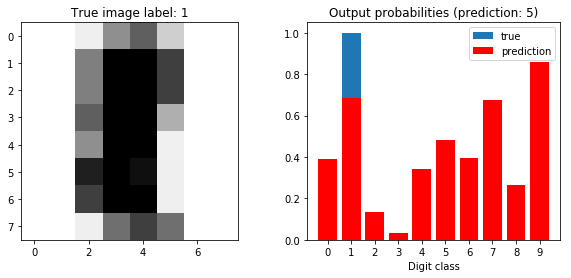

In [37]:
plot_prediction(model, sample_idx=5)

In [38]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 42.00000, train acc: 0.095, test acc: 0.081
Epoch #1, train loss: 42.00000, train acc: 0.103, test acc: 0.104
Epoch #2, train loss: 42.00000, train acc: 0.113, test acc: 0.107
Epoch #3, train loss: 42.00000, train acc: 0.104, test acc: 0.107
Epoch #4, train loss: 42.00000, train acc: 0.111, test acc: 0.148
Epoch #5, train loss: 42.00000, train acc: 0.096, test acc: 0.100
Epoch #6, train loss: 42.00000, train acc: 0.089, test acc: 0.096
Epoch #7, train loss: 42.00000, train acc: 0.092, test acc: 0.093
Epoch #8, train loss: 42.00000, train acc: 0.098, test acc: 0.078
Epoch #9, train loss: 42.00000, train acc: 0.105, test acc: 0.081
Epoch #10, train loss: 42.00000, train acc: 0.088, test acc: 0.104
Epoch #11, train loss: 42.00000, train acc: 0.089, test acc: 0.089
Epoch #12, train loss: 42.00000, train acc: 0.104, test acc: 0.100
Epoch #13, train loss: 42.00000, train acc: 0.107, test acc: 0.085
Epoch #14, train loss: 42.00000, train acc: 0.108, test acc: 0.100
Ep

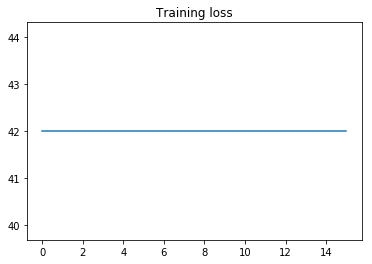

In [39]:
plt.plot(losses)
plt.title("Training loss");

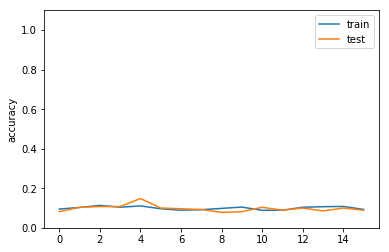

In [40]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

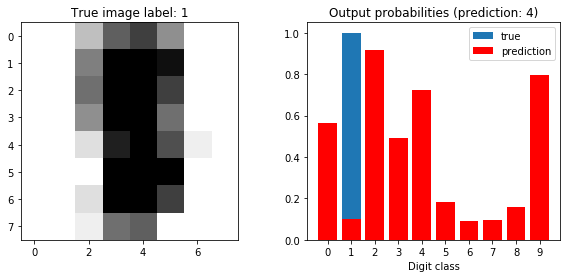

In [41]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

In [42]:
# %load solutions/worst_predictions.py

### Hyper parameters settings

- Experiment with different hyper parameters:
  - learning rate,
  - size of hidden layer,
  - initialization scheme: test with 0 initialization vs uniform,
  - implement other activation functions,
  - implement the support for a second hidden layer.


### Mini-batches

- The current implementations of `train` and `grad_loss` function currently only accept a single sample at a time:
    - implement the support for training with a mini-batch of 32 samples at a time instead of one,
    - experiment with different sizes of batches,
    - monitor the norm of the average gradients on the full training set at the end of each epoch.


### Momentum

- Bonus: Implement momentum


### Back to Keras

- Implement the same network architecture with Keras;

- Check that the Keras model can approximately reproduce the behavior of the Numpy model when using similar hyperparameter values (size of the model, type of activations, learning rate value and use of momentum);

- Compute the negative log likelihood of a sample 42 in the test set (can use `model.predict_proba`);

- Compute the average negative log-likelihood on the full test set.

- Compute the average negative log-likelihood  on the full training set and check that you can get the value of the loss reported by Keras.

- Is the model overfitting or underfitting? (ensure that the model has fully converged by increasing the number of epochs to 50 or more if necessary).

In [45]:
# %load solutions/keras_model.py
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical

n_features = 8 * 8
n_classes = 10
n_hidden = 10

keras_model = Sequential()
keras_model.add(Dense(n_hidden, input_dim=n_features, activation='sigmoid'))
keras_model.add(Dense(n_classes, activation='softmax'))

keras_model.compile(optimizer=SGD(lr=3),
                    loss='categorical_crossentropy', metrics=['accuracy'])

keras_model.fit(X_train, to_categorical(y_train), epochs=15, batch_size=32);

Using TensorFlow backend.


Epoch 1/15
1527/1527 [==============================] - 0s 100us/step - loss: 0.8293 - acc: 0.7734
Epoch 2/15
1527/1527 [==============================] - 0s 56us/step - loss: 0.2115 - acc: 0.9561
Epoch 3/15
1527/1527 [==============================] - 0s 53us/step - loss: 0.1351 - acc: 0.9692
Epoch 4/15
1527/1527 [==============================] - 0s 54us/step - loss: 0.1042 - acc: 0.9771
Epoch 5/15
1527/1527 [==============================] - 0s 53us/step - loss: 0.0796 - acc: 0.9876
Epoch 6/15
1527/1527 [==============================] - 0s 55us/step - loss: 0.0618 - acc: 0.9895
Epoch 7/15
1527/1527 [==============================] - 0s 66us/step - loss: 0.0463 - acc: 0.9961
Epoch 8/15
1527/1527 [==============================] - 0s 58us/step - loss: 0.0392 - acc: 0.9967
Epoch 9/15
1527/1527 [==============================] - 0s 54us/step - loss: 0.0325 - acc: 0.9987
Epoch 10/15
1527/1527 [==============================] - 0s 57us/step - loss: 0.0288 - acc: 0.9967
Epoch 11/15
1527/1

Predicted probability distribution for sample #42:
0: 0.00001
1: 0.00003
2: 0.00002
3: 0.00002
4: 0.00001
5: 0.00000
6: 0.00002
7: 0.00000
8: 0.99973
9: 0.00017

Likelihood of true class for sample #42:
0.9997303

Negative Log Likelihood of true class for sample #42:
0.0002697474

Average negative loglikelihood of the test set:
0.10019322900991905


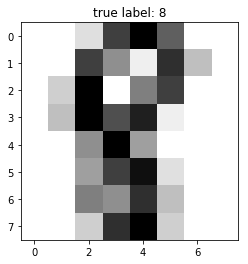

In [48]:
# %load solutions/keras_model_test_loss.py
sample_idx = 42
plt.imshow(scaler.inverse_transform(X_test[sample_idx]).reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("true label: %d" % y_test[sample_idx])

# Compute all probabilities for all samples in the test set at
# once:
probabilities = keras_model.predict_proba(X_test, verbose=0)

print("Predicted probability distribution for sample #42:")
for class_idx, prob in enumerate(probabilities[sample_idx]):
    print("%d: %0.5f" % (class_idx, prob))
print()
    
print("Likelihood of true class for sample #42:")
p_42 = probabilities[sample_idx, y_test[sample_idx]]
print(p_42)
print()

print("Negative Log Likelihood of true class for sample #42:")
print(-np.log(p_42))
print()

print("Average negative loglikelihood of the test set:")
Y_test = to_categorical(y_test)
loglikelihoods = np.sum(np.log(probabilities) * Y_test, axis=1)
print(-np.mean(loglikelihoods))

# Analysis
#
# Depending on the random init, the 2 hidden layers net trained with
# sgd or adam seem to converge to a training loss very close to zero when
# given enough epochs (the accuracy on the training set is 100%).
# This model is therefore not underfitting: it has enough capacity
# to perfectly memorise the full training set.
#
# On the test set the negative log likelihood is also close to zero
# but never as much as on the training set (~ 0.1) even after
# increasing the maximum number of epochs. The model is therefore
# overfitting a little.

## Homework assignments

- Watch the following video on [how to code a minimal deep learning framework](https://www.youtube.com/watch?v=o64FV-ez6Gw) that feels like a simplified version
of Keras but using numpy instead of tensorflow:

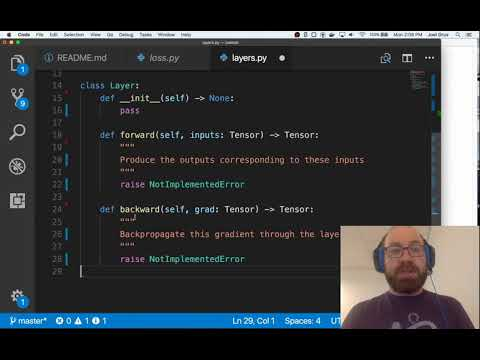

In [49]:
from IPython.display import YouTubeVideo
YouTubeVideo("o64FV-ez6Gw")

- **Optional**: read the following blog post on Reverse-Mode Automatic Differentiation from start to section "A simple implementation in Python" included:

  https://rufflewind.com/2016-12-30/reverse-mode-automatic-differentiation